In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

df = pd.read_csv('SpotifyFeatures.csv') 






### Limpieza Dataset Spotify

In [1]:
# Cargar el dataset
df = pd.read_csv("SpotifyFeatures.csv")

# 1. Valores faltantes
print("Valores faltantes por:")
print(df.isnull().sum())
df.fillna(df.mean(numeric_only=True), inplace=True)

# 2. Identificar outliers
numerical_columns = df.select_dtypes(include=['float64', 'int64']).columns
Q1 = df[numerical_columns].quantile(0.25)
Q3 = df[numerical_columns].quantile(0.75)
IQR = Q3 - Q1
outliers = ((df[numerical_columns] < (Q1 - 1.5 * IQR)) | (df[numerical_columns] > (Q3 + 1.5 * IQR)))
print("Número de outliers:")
print(outliers.sum())

# 3. Estandarizar formatos
df['track_id'] = df['track_id'].astype(str)  # ID como texto
df['duration_ms'] = df['duration_ms'].astype(int)  # Asegurar duración como entero
df['time_signature'] = df['time_signature'].str.replace('/4', '').astype(int)  # Compases 

# 4. Identificar y eliminar duplicados
print(f"Número de filas duplicadas: {df.duplicated().sum()}")
df = df.drop_duplicates()

NameError: name 'pd' is not defined

### RFM

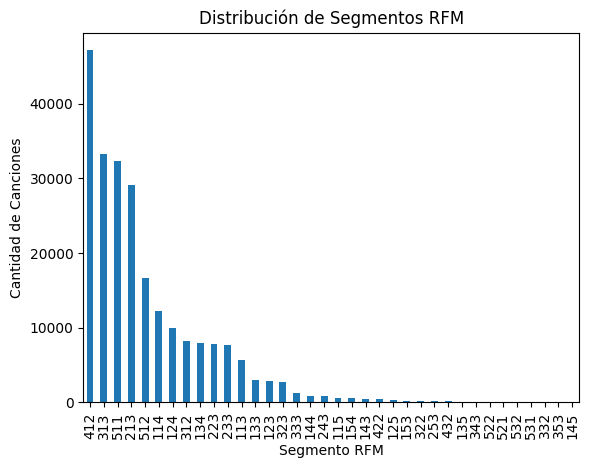

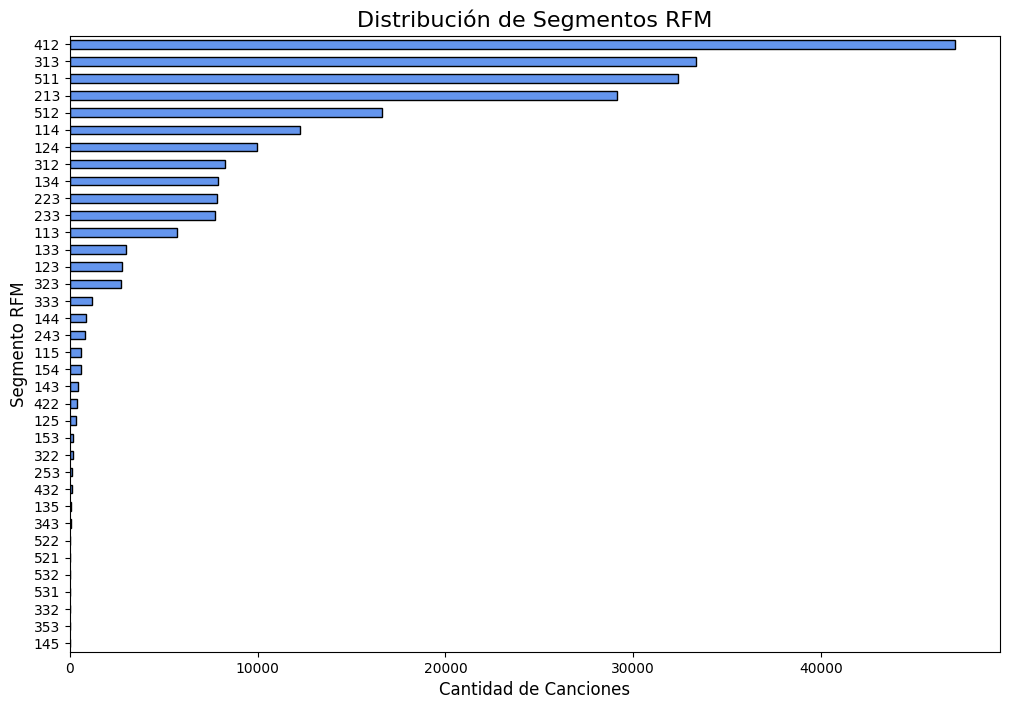

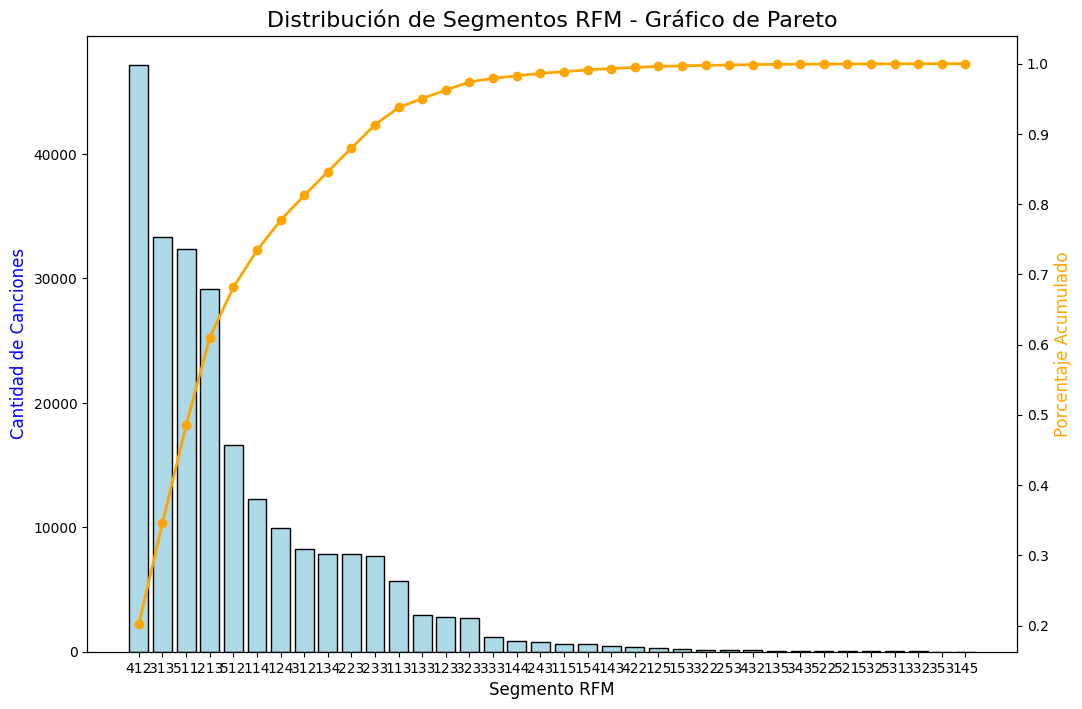

C:\Users\benja\AppData\Local\Temp\ipykernel_8040\891629258.py:71: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=rfm_counts.index, y=rfm_counts.values, palette=colors)


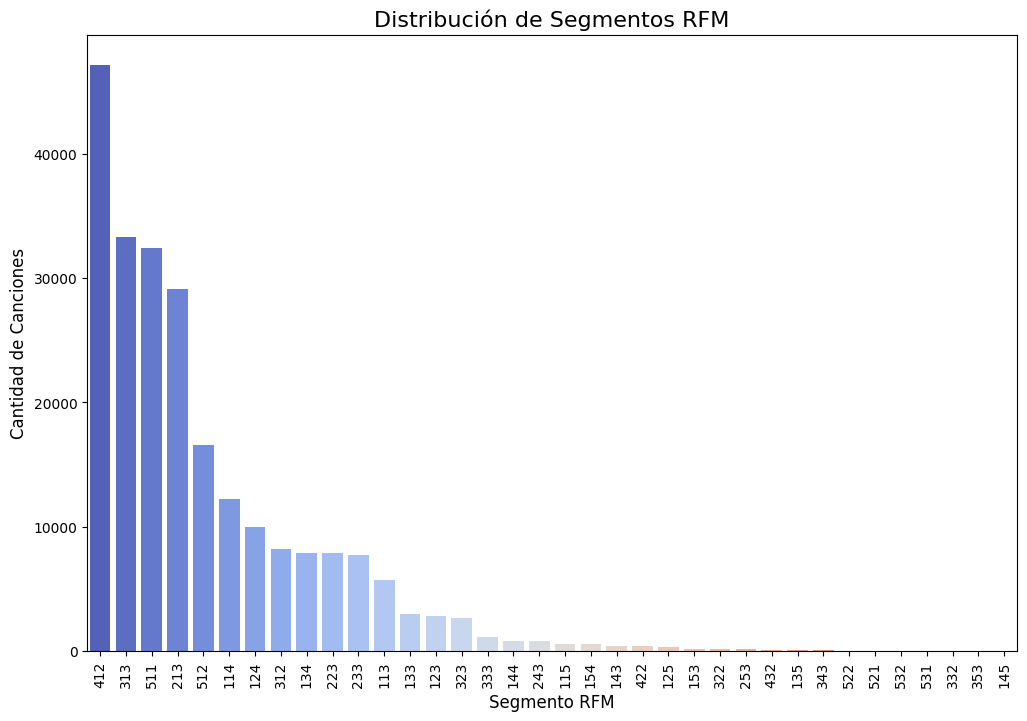

In [3]:
# 1. RFM - Calcular métricas
# R: Última vez escuchada, F: Frecuencia de aparición, M: Popularidad
df['recency'] = df['popularity'].rank(ascending=False)  # ranking para 'recency'
df['frequency'] = df.groupby('track_id')['track_id'].transform('count')  # Frecuencia de cada canción
df['monetary'] = df['popularity']  # popularidad como valor monetario

# 2. Asignar Scores (1-5)
df['R_score'] = pd.cut(df['recency'], bins=5, labels=[1, 2, 3, 4, 5])
df['F_score'] = pd.cut(df['frequency'], bins=5, labels=[1, 2, 3, 4, 5])
df['M_score'] = pd.cut(df['monetary'], bins=5, labels=[1, 2, 3, 4, 5])

# 3. Crear Segmentos
df['RFM_Segment'] = df['R_score'].astype(str) + df['F_score'].astype(str) + df['M_score'].astype(str)

# 4. Visualización
import matplotlib.pyplot as plt
df['RFM_Segment'].value_counts().plot(kind='bar')
plt.title("Distribución de Segmentos RFM")
plt.xlabel("Segmento RFM")
plt.ylabel("Cantidad de Canciones")
plt.show()

#Gráficos distintos 

import matplotlib.pyplot as plt

# Ordenar los segmentos RFM por cantidad
rfm_counts = df['RFM_Segment'].value_counts().sort_values(ascending=False)

# Gráfico de barras horizontal
plt.figure(figsize=(12, 8))
rfm_counts.plot(kind='barh', color='cornflowerblue', edgecolor='black')
plt.title('Distribución de Segmentos RFM', fontsize=16)
plt.xlabel('Cantidad de Canciones', fontsize=12)
plt.ylabel('Segmento RFM', fontsize=12)
plt.gca().invert_yaxis()  # Invierte el eje Y para que los valores más altos estén arriba
plt.show()

import numpy as np

# Ordenar segmentos y calcular acumulado
rfm_counts = df['RFM_Segment'].value_counts().sort_values(ascending=False)
cumulative = rfm_counts.cumsum() / rfm_counts.sum()

# Gráfico tipo Pareto
fig, ax1 = plt.subplots(figsize=(12, 8))

# Barras
ax1.bar(rfm_counts.index, rfm_counts, color='lightblue', edgecolor='black')
ax1.set_xlabel('Segmento RFM', fontsize=12)
ax1.set_ylabel('Cantidad de Canciones', color='blue', fontsize=12)

# Línea acumulada
ax2 = ax1.twinx()
ax2.plot(rfm_counts.index, cumulative, color='orange', marker='o', linestyle='-', linewidth=2)
ax2.set_ylabel('Porcentaje Acumulado', color='orange', fontsize=12)

plt.title('Distribución de Segmentos RFM - Gráfico de Pareto', fontsize=16)
plt.show()

import seaborn as sns

# Preparar los datos
rfm_counts = df['RFM_Segment'].value_counts().sort_values(ascending=False)

# Paleta de colores
colors = sns.color_palette("coolwarm", len(rfm_counts))

# Gráfico con colores personalizados
plt.figure(figsize=(12, 8))
sns.barplot(x=rfm_counts.index, y=rfm_counts.values, palette=colors)
plt.title('Distribución de Segmentos RFM', fontsize=16)
plt.xlabel('Segmento RFM', fontsize=12)
plt.ylabel('Cantidad de Canciones', fontsize=12)
plt.xticks(rotation=90)
plt.show()



### Segmentación

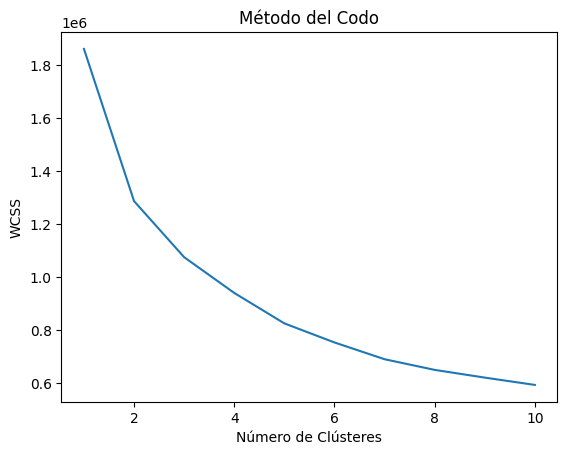

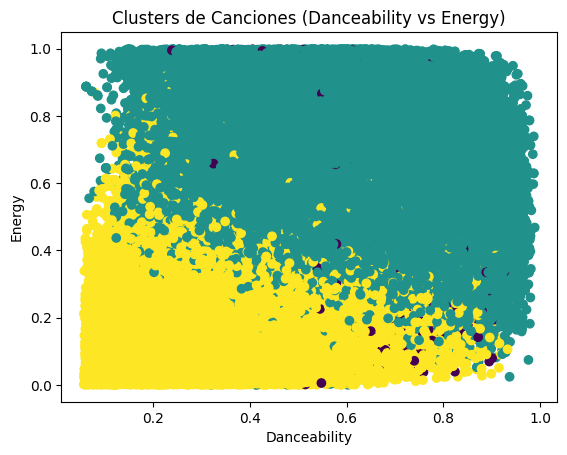

In [4]:
# 1. Preparación
features = ['acousticness', 'danceability', 'energy', 'instrumentalness', 'loudness', 'speechiness', 'tempo', 'valence']
df_features = df[features]
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_features)

# 2. Clustering - Método del codo
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_)

# método del codo
plt.plot(range(1, 11), wcss)
plt.title('Método del Codo')
plt.xlabel('Número de Clústeres')
plt.ylabel('WCSS')
plt.show()

# 3. K-means
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
df['Cluster'] = kmeans.fit_predict(df_scaled)

# Visualización
plt.scatter(df['danceability'], df['energy'], c=df['Cluster'], cmap='viridis')
plt.title("Clusters de Canciones (Danceability vs Energy)")
plt.xlabel('Danceability')
plt.ylabel('Energy')
plt.show()


### CLV

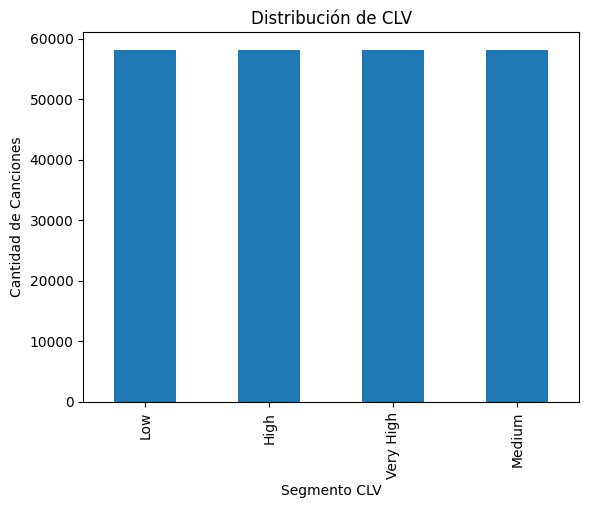

In [5]:
# 1. Métricas base (Valor promedio, Frecuencia, Tiempo de vida)
df['avg_value'] = df['popularity'].mean()  # Valor promedio de las canciones
df['frequency'] = df.groupby('track_id')['track_id'].transform('count')  # Frecuencia
df['lifetime'] = df['duration_ms'] / 1000 / 60  # Tiempo de vida en minutos

# 2. Cálculo CLV (Valor Promedio * Frecuencia * Tiempo de vida)
df['CLV'] = df['avg_value'] * df['frequency'] * df['lifetime']

# 3. Segmentación
df['CLV_segment'] = pd.qcut(df['CLV'], 4, labels=['Low', 'Medium', 'High', 'Very High'])

# 4. Visualización
df['CLV_segment'].value_counts().plot(kind='bar')
plt.title("Distribución de CLV")
plt.xlabel("Segmento CLV")
plt.ylabel("Cantidad de Canciones")
plt.show()

### Análisis de Tendencias 

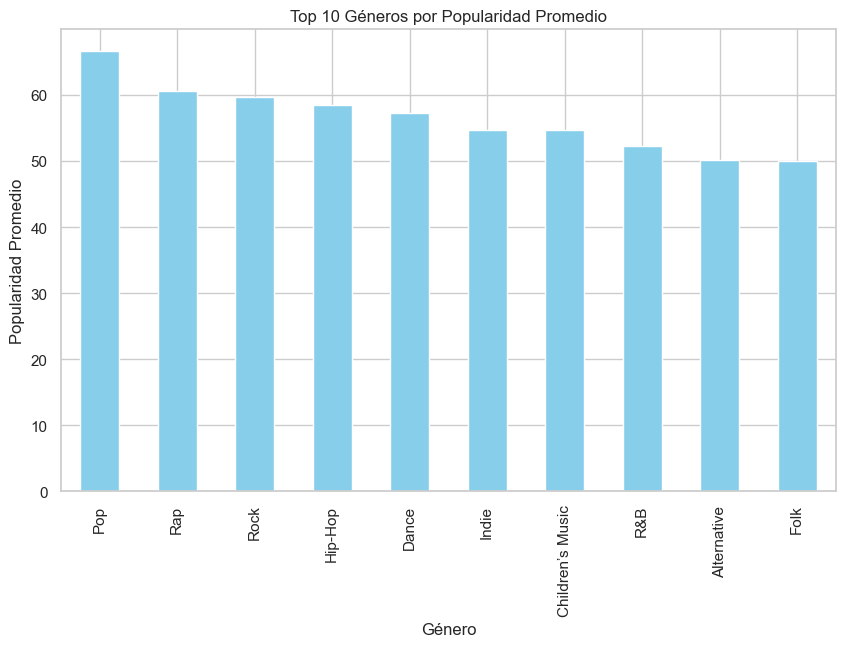

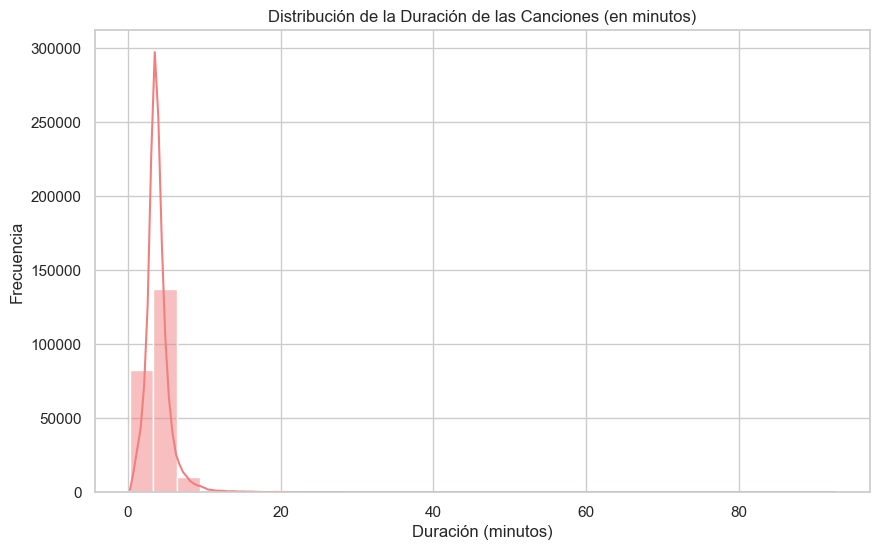

C:\Users\benja\AppData\Local\Temp\ipykernel_8040\2469711310.py:28: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='genre', y='popularity', data=df, palette='viridis')


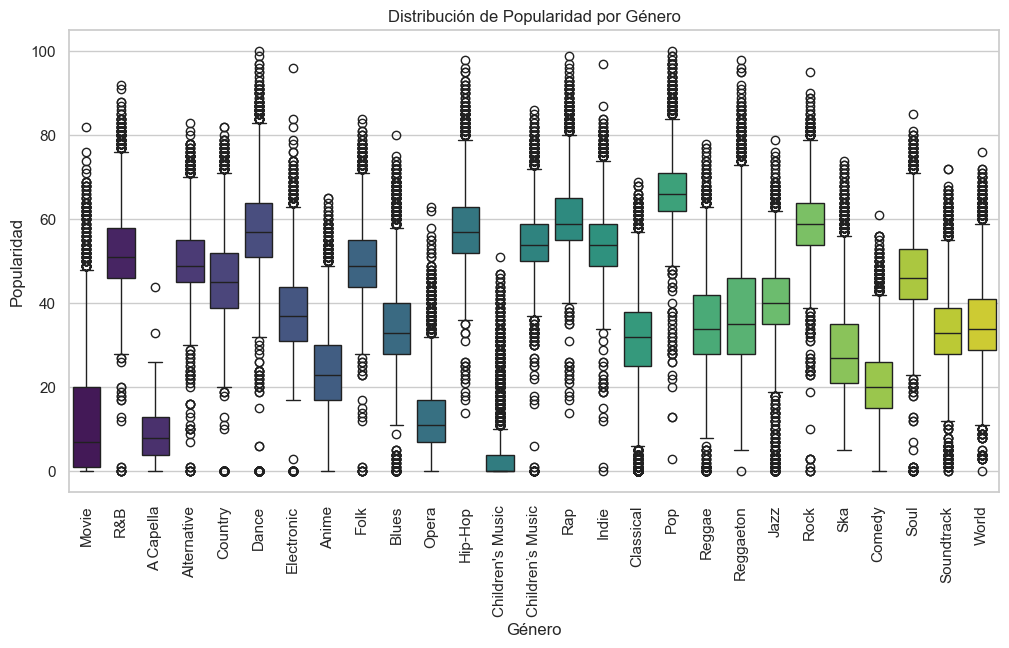

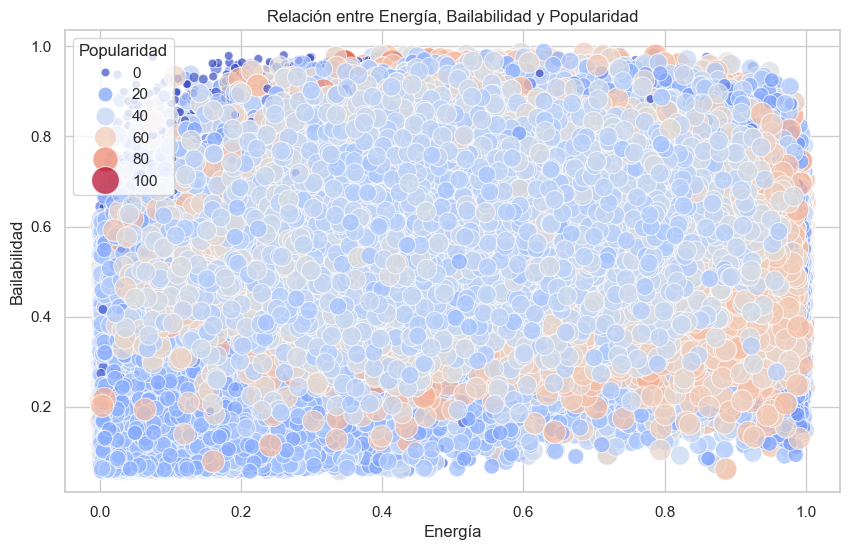

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
sns.set(style="whitegrid")

# Análisis de tendencia: Popularidad por género
popularity_by_genre = df.groupby('genre')['popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
popularity_by_genre.plot(kind='bar', color='skyblue')
plt.title('Top 10 Géneros por Popularidad Promedio')
plt.ylabel('Popularidad Promedio')
plt.xlabel('Género')
plt.show()

# Tendencia de duración de canciones
plt.figure(figsize=(10, 6))
sns.histplot(df['duration_ms'] / 60000, bins=30, kde=True, color='lightcoral')
plt.title('Distribución de la Duración de las Canciones (en minutos)')
plt.xlabel('Duración (minutos)')
plt.ylabel('Frecuencia')
plt.show()

# Distintos gráficos 

plt.figure(figsize=(12, 6))
sns.boxplot(x='genre', y='popularity', data=df, palette='viridis')
plt.title('Distribución de Popularidad por Género')
plt.xticks(rotation=90)  # Rotar etiquetas del eje X
plt.xlabel('Género')
plt.ylabel('Popularidad')
plt.show()

plt.figure(figsize=(10, 6))
sns.scatterplot(x='energy', y='danceability', data=df, hue='popularity', size='popularity',
                sizes=(40, 400), palette='coolwarm', alpha=0.7)
plt.title('Relación entre Energía, Bailabilidad y Popularidad')
plt.xlabel('Energía')
plt.ylabel('Bailabilidad')
plt.legend(title='Popularidad')
plt.show()



### Revisión de Métricas Digitales Actuales 

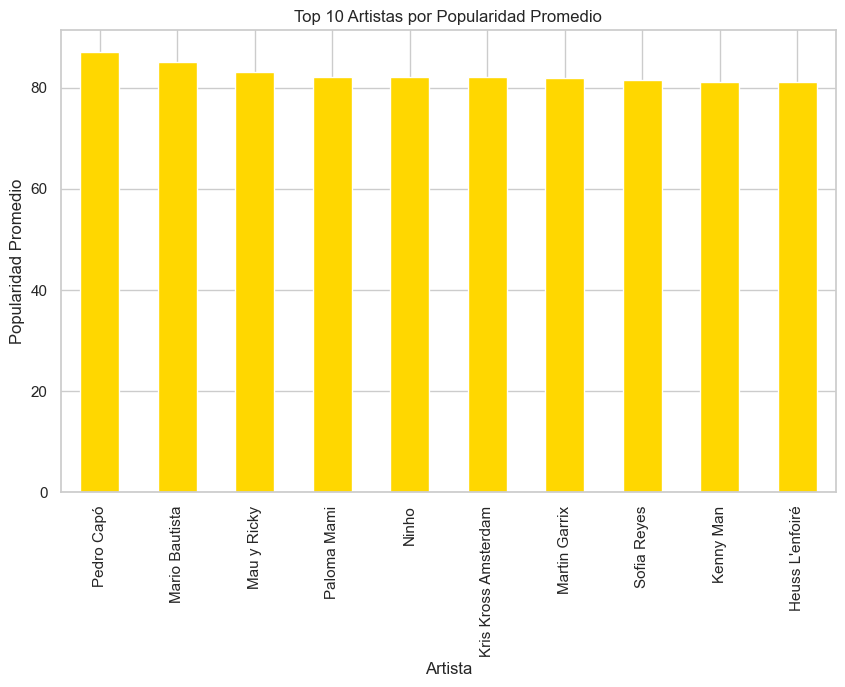

C:\Users\benja\AppData\Roaming\Python\Python313\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


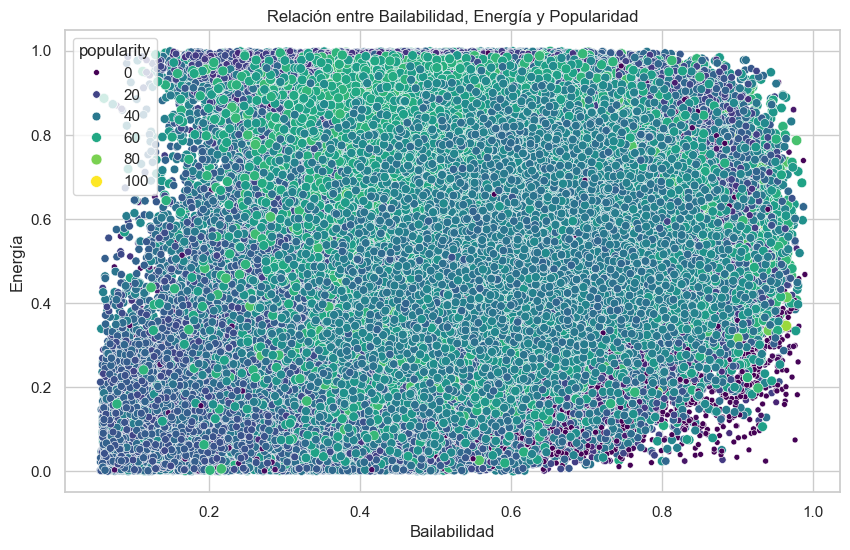

In [7]:
# Top 10 artistas más populares
top_artists = df.groupby('artist_name')['popularity'].mean().sort_values(ascending=False).head(10)

plt.figure(figsize=(10, 6))
top_artists.plot(kind='bar', color='gold')
plt.title('Top 10 Artistas por Popularidad Promedio')
plt.ylabel('Popularidad Promedio')
plt.xlabel('Artista')
plt.show()

# Métricas digitales: Bailabilidad y energía
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='danceability', y='energy', hue='popularity', palette='viridis', size='popularity')
plt.title('Relación entre Bailabilidad, Energía y Popularidad')
plt.xlabel('Bailabilidad')
plt.ylabel('Energía')
plt.show()


### Análisis de Sentimientos 

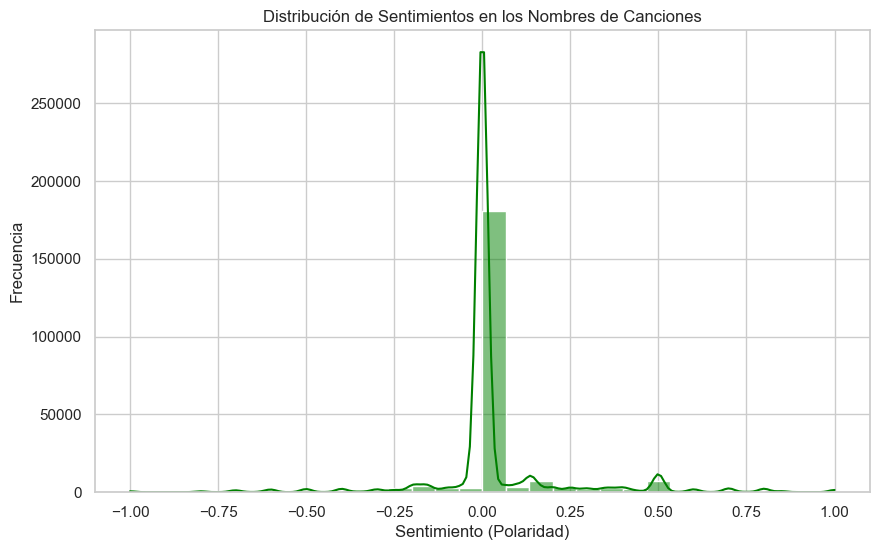

Top 5 canciones más positivas:
                                       track_name  sentiment
109085                               Best Mistake        1.0
118151                                    Perfect        1.0
226615                              companions <3        1.0
2694                                    Priceless        1.0
136766  Greatest Hits - Extended Rarities Version        1.0

Top 5 canciones más negativas:
                                            track_name  sentiment
51559                            Evil Got a Hold on Me       -1.0
96827                       Cruel To Care (Voice Memo)       -1.0
96567   Heaven Knows I'm Miserable Now - 2011 Remaster       -1.0
111990                                 Nasty Freestyle       -1.0
95930                                      Grim Reaper       -1.0


In [8]:
from textblob import TextBlob

# Función para analizar sentimiento
def obtener_sentimiento(texto):
    return TextBlob(str(texto)).sentiment.polarity

# Aplicamos el análisis de sentimiento a los nombres de canciones
df['sentiment'] = df['track_name'].apply(obtener_sentimiento)

# Visualizamos distribución de sentimiento
plt.figure(figsize=(10, 6))
sns.histplot(df['sentiment'], bins=30, kde=True, color='green')
plt.title('Distribución de Sentimientos en los Nombres de Canciones')
plt.xlabel('Sentimiento (Polaridad)')
plt.ylabel('Frecuencia')
plt.show()

# Top 5 canciones con sentimiento positivo y negativo
print("Top 5 canciones más positivas:")
print(df.sort_values(by='sentiment', ascending=False)[['track_name', 'sentiment']].head())

print("\nTop 5 canciones más negativas:")
print(df.sort_values(by='sentiment')[['track_name', 'sentiment']].head())


In [9]:
# Exportar el DataFrame a un archivo CSV
df.to_csv('SpotifyFeatures_analizado.csv', index=False)
print("Archivo exportado correctamente.")


Archivo exportado correctamente.


In [10]:

# Guardar el DataFrame actual en un archivo CSV
df.to_csv('SpotifyFeatures_final.csv', index=False)
print("Archivo guardado correctamente como SpotifyFeatures_final.csv")


Archivo guardado correctamente como SpotifyFeatures_final.csv
